# Homework 4

## Follow These Steps Before Submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.


# 1. Wisconsin Breast Cancer Dataset

In this assignment, you will use a modified version of the well-known Wisconsin Breast Cancer dataset. We want to predict if a patient has a malignant or benign tumour. The features in the dataset are described below:


**Cl.thickness**:	Clump Thickness

**Cell.size**:	Uniformity of Cell Size

**Cell.shape**:	Uniformity of Cell Shape

**Marg.adhesion**:	Marginal Adhesion

**Epith.c.size**:	Single Epithelial Cell Size

**Bare.nuclei**:	Bare Nuclei

**Bl.cromatin**:	Bland Chromatin

**Normal.nucleoli**:	Normal Nucleoli

**Mitoses**:	Mitoses

**Age**: Age

**Class**: 1 if malignant, 0 if benign

In [1]:
# Package import
import numpy as np

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Data management imports
import pandas as pd
import polars as pl

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Uncomment the line below if you are using Google colab
# !gdown https://drive.google.com/uc?id=12Y-PdpmPLInGGBvFAn_G3eCfXrRETvuF

1. Read the CSV file using Polars and store it. Use "null_values=['NA']". Show summary statistics for the dataset. What is the baseline accuracy for a model?

In [3]:
breastcanc = pl.read_csv("Breast Cancer Data.csv", null_values=['NA'])
breastcanc.describe()

statistic,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class,Age
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",696.0,694.0,694.0,699.0,699.0,683.0,699.0,699.0,699.0,699.0,699.0
"""null_count""",3.0,5.0,5.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
"""mean""",4.426724,3.136888,3.208934,2.806867,3.216023,3.544656,3.437768,2.866953,1.569385,0.344778,50.100143
"""std""",2.815748,3.053632,2.973356,2.855379,2.2143,3.643857,2.438364,3.053634,1.619803,0.475636,17.97766
"""min""",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0
"""25%""",2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,0.0,38.0
"""50%""",4.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,0.0,50.0
"""75%""",6.0,5.0,5.0,4.0,4.0,6.0,5.0,4.0,1.0,1.0,62.0
"""max""",10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,9.0,1.0,105.0


In [4]:
posrate = breastcanc.select("Class").mean().to_numpy().item()
baselineaccuracy = 1-posrate
print(f"The baseline accuracy is {baselineaccuracy}")

The baseline accuracy is 0.6552217453505007


The baseline accuracy of the data is 0.6552217453505007

2. Assume that we are only interested in studying people aged 100 or less. Remove anyone with ages larger than that. (Note that this slightly changes your baseline accuracy.)

In [5]:
breastcanc = breastcanc.filter(
    pl.col("Age") <= 100
    )

3. Replace the missing values in the dataset using the median of the corresponding predictor.

In [6]:
breastcanc = breastcanc.with_columns(
    pl.col("Cl.thickness").fill_null(pl.col("Cl.thickness").median()),
    pl.col("Cell.size").fill_null(pl.col("Cell.size").median()),
    pl.col("Cell.shape").fill_null(pl.col("Cell.shape").median()),
    pl.col("Bare.nuclei").fill_null(pl.col("Bare.nuclei").median())
)

4. Create a training and testing dataset. Reserve 30% of the data for testing and stratify the split based on the outcome. Use a random state of 0.

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(breastcanc.drop("Class"),
                                                breastcanc.select("Class"),
                                                test_size=0.3,
                                                random_state=0,
                                                stratify=breastcanc.select("Class") # Stratify requires binary values
                                                )

5. Using all potential predictors, train a logistic regression model to predict if a patient has the condition. Remember to standardize the predictors. Use the following arguments: solver='lbfgs', penalty=None, max_iter=10000, verbose=1, random_state=0, and n_jobs=-1.

In [8]:
features_to_transform = ['Cl.thickness', 'Cell.size', 'Cell.shape', 'Marg.adhesion', 'Epith.c.size',
                         'Bare.nuclei', 'Bl.cromatin', 'Normal.nucleoli', 'Mitoses', 'Age']

# Create a ColumnTransformer object that scales the features to transform
transform_numbers = ColumnTransformer([('scaler', StandardScaler(), features_to_transform)],
                                      remainder='passthrough',
                                      verbose_feature_names_out=False,
                                      force_int_remainder_cols=False)

# Create a pipeline that scales the features and trains a logistic regression model
logit_pipe1 = Pipeline([
    ('scaler', transform_numbers),
    ('logistic_regression', LogisticRegression(solver='lbfgs',
                                               penalty = None,
                                               max_iter=10000,
                                               verbose=1,
                                               random_state=0,
                                               n_jobs=-1,
                                               class_weight='balanced'))
])

logit_pipe1.fit(Xtrain, ytrain.to_numpy().ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Pipeline(steps=[('scaler',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Cl.thickness', 'Cell.size',
                                                   'Cell.shape',
                                                   'Marg.adhesion',
                                                   'Epith.c.size',
                                                   'Bare.nuclei', 'Bl.cromatin',
                                                   'Normal.nucleoli', 'Mitoses',
                                                   'Age'])],
                                   verbose_feature_names_out=False)),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    n_jobs=-1, penalty=None, random_state=0,
                                    verbose=1))])

6. Compute the accuracy and AUC of your model on the test set.

In [9]:
accuracy = logit_pipe1.score(Xtest, ytest.to_numpy().ravel())
y_test_prediction = logit_pipe1.predict_proba(Xtest)
auc = np.round(roc_auc_score(y_true=ytest, y_score=y_test_prediction[:,1]),
               decimals = 3)
print(f"The AUC of the model is {auc}")
print(f"The accuracy of the model is {accuracy}")

The AUC of the model is 0.996
The accuracy of the model is 0.9714285714285714


- Much better accuracy of the model vs baseline accuracy
- AUC is near 1, which means that the model is much better than random chance

7. Without estimates of the uncertainty of the performance metrics, it can be hard to make definitive conclusions about the performance of the model. Compute 95% confidence intervals for the accuracy and AUC using bootstrapping with 1000 replicates. Interpret your results.

In [10]:
# Get the predicted probabilities of the test data
yprob = logit_pipe1.predict_proba(Xtest)[:, 1]

# Get the predicted classes of the test data
ypred = logit_pipe1.predict(Xtest)

n_bootstraps = 1000 # set the bootstraps amounts
bootstrapped_accuracy = np.zeros(n_bootstraps)
bootstrapped_auc = np.zeros(n_bootstraps)

for i in range(n_bootstraps):
    # Get the indices for the bootstrap sample
    idx = np.random.choice(len(ytest), len(ytest), replace=True)

    # Get the accuracy of the bootstrap sample
    bootstrapped_accuracy[i] = accuracy_score(ytest.to_pandas().iloc[idx], ypred[idx])

    # Get the AUC of the bootstrap sample
    bootstrapped_auc[i] = roc_auc_score(ytest.to_pandas().iloc[idx], yprob[idx])
    
# Get the differences between the bootstrapped values and the original values
accuracy_diff = bootstrapped_accuracy - accuracy
auc_diff = bootstrapped_auc - auc

# Calculate the 95% confidence interval for the accuracy and AUC
accuracy_ci = np.percentile(accuracy_diff, [2.5, 97.5])
auc_ci = np.percentile(auc_diff, [2.5, 97.5])

# Show the ci bounds
print(accuracy_ci)
print(auc_ci)

[-0.02380952  0.01904762]
[-0.00471637  0.00379883]


In [11]:
print(f"The 95% confidence interval for the accuracy is [{(accuracy - accuracy_ci[1])*100:.2f}%, {(accuracy - accuracy_ci[0])*100:.2f}%]")
print(f"The 95% confidence interval for the AUC is [{(auc - auc_ci[1]):.2f}, {(auc - auc_ci[0]):.2f}]")

The 95% confidence interval for the accuracy is [95.24%, 99.52%]
The 95% confidence interval for the AUC is [0.99, 1.00]


8. Plot the distribution of the accuracy and AUC using histograms. Make sure to provide a title and axes labels for your plots. Add a red vertical line representing the mean of accuracy and AUC.

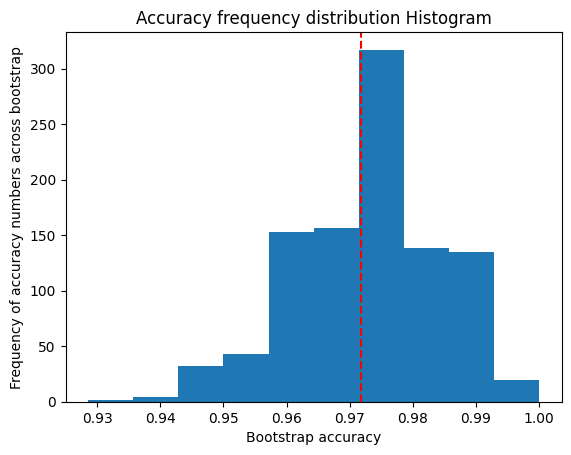

In [12]:
plt.hist(bootstrapped_accuracy)
plt.xlabel("Bootstrap accuracy")
plt.ylabel("Frequency of accuracy numbers across bootstrap")
plt.title("Accuracy frequency distribution Histogram")
plt.axvline(bootstrapped_accuracy.mean(), color='r', linestyle='dashed')
plt.show()

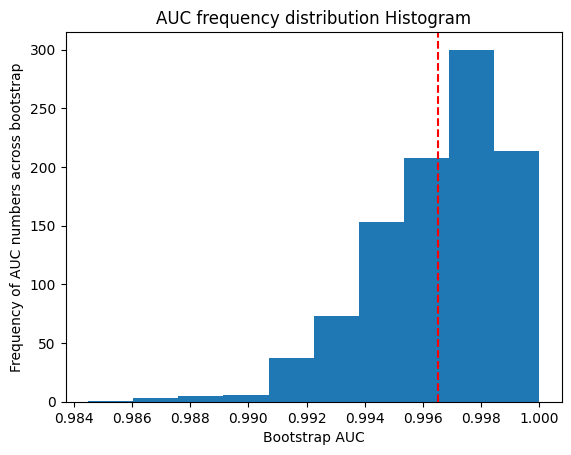

In [13]:
plt.hist(bootstrapped_auc)
plt.xlabel("Bootstrap AUC")
plt.ylabel("Frequency of AUC numbers across bootstrap")
plt.title("AUC frequency distribution Histogram")
plt.axvline(bootstrapped_auc.mean(), color='r', linestyle='dashed')
plt.show()

9. Compute 95% confidence intervals for the accuracy and AUC using repeated cross-validation. Use 10 splits and 100 repetitions with a random state of 0. Compare your results to what you obtained using bootstrapping. Which method provides better confidence intervals in this case?

In [15]:
logit_pipe = Pipeline([
    ('scaler', transform_numbers),
    ('logistic_regression', LogisticRegression(solver='lbfgs',
                                               penalty = None,
                                               max_iter=10000,
                                               verbose=0,
                                               random_state=0,
                                               n_jobs=1,
                                               class_weight='balanced'))
])

cv = RepeatedKFold(n_splits=10, n_repeats=100, random_state=0)

cv_results = cross_validate(logit_pipe, # The pipeline to cross-validate
                            breastcanc.drop('Class'), # The features
                            breastcanc.select('Class').to_numpy().ravel(), # The target
                            cv=cv, # The cross-validation object we created
                            scoring=['accuracy', 'roc_auc'], # The metrics we want to calculate
                            return_estimator=True, # Return the estimator for each fold. Useful for calculating parameter uncertainty.
                            n_jobs=-1 # Use all available cores
                            )

logit_pipe.fit(Xtrain, ytrain.to_numpy().ravel())

Pipeline(steps=[('scaler',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Cl.thickness', 'Cell.size',
                                                   'Cell.shape',
                                                   'Marg.adhesion',
                                                   'Epith.c.size',
                                                   'Bare.nuclei', 'Bl.cromatin',
                                                   'Normal.nucleoli', 'Mitoses',
                                                   'Age'])],
                                   verbose_feature_names_out=False)),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    n_jobs=1, penalty=None, random_state=0))])

In [16]:
# Get the accuracy and AUC scores
accuracy_scores = cv_results['test_accuracy']
auc_scores = cv_results['test_roc_auc']

# Calculate the mean and standard deviation of the accuracy and AUC scores
accuracy_mean = accuracy_scores.mean()
accuracy_std = accuracy_scores.std()
auc_mean = auc_scores.mean()
auc_std = auc_scores.std()

# Print the results
print(f"The CI for the model accuracy is [{(accuracy_mean - 1.96*accuracy_std)*100:.2f}%, {(accuracy_mean + 1.96*accuracy_std)*100:.2f}%]")
print(f"The CI for the AUC of the model is [{auc_mean-1.96*auc_std:.3f},{auc_mean+1.96*auc_std:.3f}]")
print(f"The mean CV accuracy value is {accuracy_mean*100:.2f}%")
print(f"The mean CV AUC value is {auc_mean:.3f}")

The CI for the model accuracy is [92.54%, 100.78%]
The CI for the AUC of the model is [0.982,1.006]
The mean CV accuracy value is 96.66%
The mean CV AUC value is 0.994


The bootstrapping gives better confidence intervals for a few reasons. 

1. The confidence intervals are more narrow on the bootstrap
2. The confidence intervals do not exceed 1 or 100% for AUC and accuracy, respectively, on the bootstrap. Cross-validation does, which does not make sense according to the definitions of these two numbers.

10. Using your cross-validation results, compute a 95% confidence interval for each coefficient in the model. Which feature(s) might you remove based on this?

In [ ]:
# Get the coefficients of the logistic regression model for each fold
coefs = [est.named_steps['logistic_regression'].coef_ for est in cv_results['estimator']]

# Get the intercept of the logistic regression model for each fold
intercepts = [est.named_steps['logistic_regression'].intercept_ for est in cv_results['estimator']]

# Get the mean and standard deviation of the coefficients
coefs_mean = np.mean(coefs, axis=0)
coefs_std = np.std(coefs, axis=0)

# Get the mean and standard deviation of the intercept
intercept_mean = np.mean(intercepts)
intercept_std = np.std(intercepts)

# Get the feature names
feature_names = Xtrain.columns

# Create a Dataframe with three variables: The coefficient names, the mean of the coefficients, and the standard deviation of the coefficients
coefs_df = pd.DataFrame({'feature': feature_names, 'mean': coefs_mean.ravel(), 'std': coefs_std.ravel()})

# Add the mean and standard deviation of the intercept to the DataFrame
coefs_df.loc[len(coefs_df)] = ['intercept', intercept_mean, intercept_std]

# Add columns with the lower and upper bounds of the 95% confidence interval
coefs_df['lower'] = coefs_df['mean'] - 1.96*coefs_df['std']
coefs_df['upper'] = coefs_df['mean'] + 1.96*coefs_df['std']


# Print the results
coefs_df

,feature,mean,std,lower,upper
0,Cl.thickness,1.652179,0.179602,1.300160,2.004198
1,Cell.size,0.046868,0.258338,-0.459474,0.553210
2,Cell.shape,1.028028,0.204740,0.626738,1.429319
3,Marg.adhesion,0.821916,0.176131,0.476699,1.167133
4,Epith.c.size,0.041184,0.176677,-0.305103,0.387472
5,Bare.nuclei,1.749631,0.199889,1.357848,2.141414
6,Bl.cromatin,1.055497,0.196340,0.670671,1.440322
7,Normal.nucleoli,0.538368,0.157424,0.229816,0.846920
8,Mitoses,0.999209,0.165738,0.674363,1.324054
9,Age,0.324522,0.149568,0.031369,0.617675


I would remove the 'Cell.size' and 'Epith.c.size' based on the fact they are near 0 and do not affect the classification of the tumor as benign or malignant very much.

11. Fit your logistic regression model like before but remove the feature(s) you indentified in Q10. Plot the ROC curve of the model over the test set and annotate it with the AUC of the model.

In [ ]:
breastcanc2 = breastcanc.drop("Cell.size")
breastcanc2 = breastcanc2.drop("Epith.c.size")

Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(breastcanc2.drop("Class"),
                                                breastcanc2.select("Class"),
                                                test_size=0.3,
                                                random_state=0,
                                                stratify=breastcanc2.select("Class") # Stratify requires binary values
                                                )

features_to_transform2 = ['Cl.thickness', 'Cell.shape', 'Marg.adhesion',
                         'Bare.nuclei', 'Bl.cromatin', 'Normal.nucleoli', 'Mitoses', 'Age']

# Create a ColumnTransformer object that scales the features to transform
transform_numbers2 = ColumnTransformer([('scaler', StandardScaler(), features_to_transform2)],
                                      remainder='passthrough',
                                      verbose_feature_names_out=False,
                                      force_int_remainder_cols=False)

# Create a pipeline that scales the features and trains a logistic regression model
logit_pipe2 = Pipeline([
    ('scaler', transform_numbers2),
    ('logistic_regression', LogisticRegression(solver='lbfgs',
                                               penalty = None,
                                               max_iter=10000,
                                               verbose=1,
                                               random_state=0,
                                               n_jobs=-1,
                                               class_weight='balanced'))
])

logit_pipe2.fit(Xtrain2, ytrain2.to_numpy().ravel())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Pipeline(steps=[('scaler',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  ['Cl.thickness', 'Cell.shape',
                                                   'Marg.adhesion',
                                                   'Bare.nuclei', 'Bl.cromatin',
                                                   'Normal.nucleoli', 'Mitoses',
                                                   'Age'])],
                                   verbose_feature_names_out=False)),
                ('logistic_regression',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    n_jobs=-1, penalty=None, random_state=0,
                                    verbose=1))])

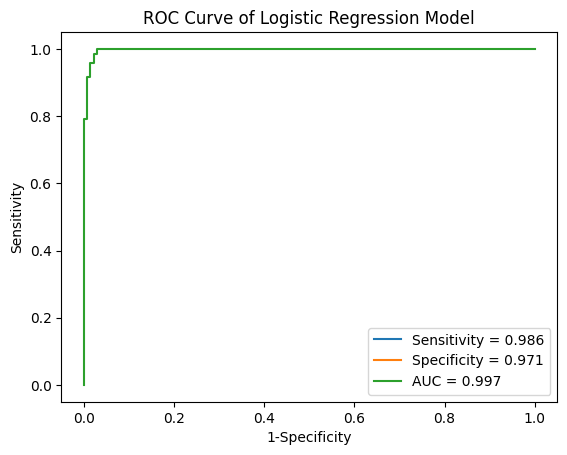

In [ ]:
y_test_prediction = logit_pipe2.predict_proba(Xtest2)
fpr, tpr, thresholds = roc_curve(y_true=ytest2, y_score=y_test_prediction[:,1])
auc2 = np.round(roc_auc_score(y_true=ytest2, y_score=y_test_prediction[:,1]),
               decimals = 3)
confusion_matrix_log = confusion_matrix(ytest2, logit_pipe2.predict(Xtest2))
sensitivity = confusion_matrix_log[1,1] / (confusion_matrix_log[1,1] + confusion_matrix_log[1,0])
specificity = confusion_matrix_log[0,0] / (confusion_matrix_log[0,0] + confusion_matrix_log[0,1])


# Plot ROC curve
plt.plot(sensitivity, label=f"Sensitivity = {sensitivity:.3f}")
plt.plot(specificity, label=f"Specificity = {specificity:.3f}")
plt.plot(fpr,tpr,label=f"AUC = {auc2:.3f}")
plt.legend(loc=4)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve of Logistic Regression Model')
plt.show()

12. Calculate the uncertainty for the prediction of the first testing patient.  Plot a histogram of the different predictions. Give the plot a title and axes labels. Add a red vertical line representing the mean of the predictions.

Hint: If you need to stack a list of arrays, you can use [np.hstack(list)](https://numpy.org/doc/stable/reference/generated/numpy.hstack.html).

In [ ]:
y_test_prediction2 = []
for i in range(len(Xtest)):
    prob = logit_pipe.predict_proba(Xtest[:1])[:,1]
    y_test_prediction2.append(prob)


bootstrap_preds = np.hstack(y_test_prediction2)
uncertainty = np.std(bootstrap_preds)
print(f"The uncertainty of the first testing patient is {uncertainty}")


The uncertainty of the first testing patient is 3.469446951953614e-18


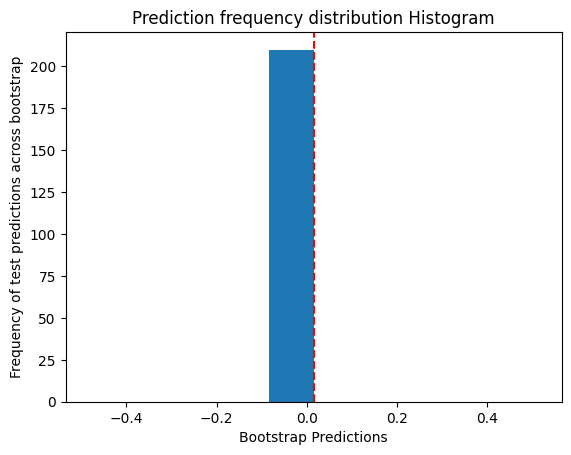

In [ ]:
plt.hist(bootstrap_preds)
plt.xlabel("Bootstrap Predictions")
plt.ylabel("Frequency of test predictions across bootstrap")
plt.title("Prediction frequency distribution Histogram")
plt.axvline(bootstrap_preds.mean(), color='r', linestyle='dashed')
plt.show()